In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [3]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         1084 non-null   object 
 1   SeasonNumber                 1084 non-null   int64  
 2   SeasonVersion                1084 non-null   int64  
 3   Player                       1084 non-null   object 
 4   MatchId                      1084 non-null   object 
 5   Map                          1084 non-null   object 
 6   Category                     1084 non-null   object 
 7   Playlist                     1084 non-null   object 
 8   Input                        1084 non-null   object 
 9   Queue                        1084 non-null   object 
 10  PreCsr                       1084 non-null   int64  
 11  PostCsr                      1084 non-null   int64  
 12  WinningTeam                  13 non-null     object 
 13  WinningTeamCSR    

In [4]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/Life'] = df['DamageDone'] / df['Deaths'].replace(0,1)
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map', 'WinningTeamScore',
            'WinningTeam','WinningTeamCSR', 'WinningTeamMMR', 'WinningTeamFinalScore', 'WinningTeamWinPercentChance',
            'LosingTeam', 'LosingTeamCSR', 'LosingTeamMMR', 'LosingTeamScore' ,'LosingTeamFinalScore',
            'LosingTeamWinPercentChance'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804 entries, 140 to 1083
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         804 non-null    int64  
 1   Accuracy        804 non-null    float64
 2   DamageDone      804 non-null    int64  
 3   DamageTaken     804 non-null    int64  
 4   KD              804 non-null    float64
 5   KDA             804 non-null    float64
 6   Kills           804 non-null    int64  
 7   Deaths          804 non-null    int64  
 8   Assists         804 non-null    int64  
 9   MaxSpree        804 non-null    int64  
 10  ExpectedKills   804 non-null    float64
 11  ExpectedDeaths  804 non-null    float64
 12  Score           804 non-null    int64  
 13  Medals          804 non-null    int64  
 14  LengthMinutes   804 non-null    float64
 15  DamageRatio     804 non-null    float64
 16  Damage/Kill     804 non-null    float64
 17  Damage/Life     804 non-null    

In [5]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [6]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.448042
DmgT/10Min        0.370961
Damage/Life       0.331484
KD                0.326423
Deaths            0.325768
KDA               0.294568
Damage/KA         0.288187
ExcessDeaths      0.270371
DamageTaken       0.253385
ExpectedDeaths    0.209988
Damage/Kill       0.191685
Assists/10Min     0.166317
Kills/10Min       0.153936
LengthMinutes     0.135481
DamageDone        0.091512
Accuracy          0.089448
MaxSpree          0.080246
Assists           0.052529
HSPct             0.038754
ExpectedKills     0.037627
Score             0.036488
DamageRatio       0.035995
BodyPct           0.033692
Dmg/10Min         0.030800
PowerPct          0.030628
ExcessKills       0.028413
Medals            0.016745
GrenadePct        0.012717
Kills             0.008134
MeleePct          0.004865
Shots/10Min       0.000689
Name: Outcome, dtype: float64


In [7]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [8]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,804.0,0.553483,0.497441,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,804.0,52.874428,5.523445,20.450000,49.390000,52.895000,56.347500,80.560000
DamageDone,804.0,5317.914179,1835.738165,619.000000,3928.000000,5100.000000,6537.000000,12673.000000
DamageTaken,804.0,4568.631841,1552.413793,0.000000,3497.750000,4405.500000,5602.500000,9962.000000
KD,804.0,1.262289,0.735203,0.230000,0.830000,1.120000,1.450000,10.000000
KDA,804.0,4.489826,5.769308,-10.000000,0.660000,4.330000,7.745000,31.000000
Kills,804.0,14.628109,6.312316,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,804.0,13.022388,5.148552,0.000000,10.000000,13.000000,16.000000,32.000000
Assists,804.0,8.657960,4.251575,0.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,804.0,3.947761,1.661147,1.000000,3.000000,4.000000,5.000000,15.000000


In [9]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (804, 31)
Y Shape: (804,)


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (643, 31)
X Test Shape: (161, 31)
Y Train Mean: 0.552
Y Test Mean: 0.559


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 'Damage/Life',
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)


print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')
# X_train_preprocessed.head()

X Train Processed Shape: (643, 31)
X Train Shape: (643, 31)
X Test Processed Shape: (161, 31)


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=False)

  # Print or analyze the top 10 sorted feature coefficients
  print("Top 10 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:10]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [14]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.7639751552795031
Acc: 0.764
MAE: 0.24
MSE: 0.24
RMSE: 0.49
R^2 Score: 0.04
OOS R^2 Score: 0.04
Log Loss: 8.51
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        71
           1       0.82      0.74      0.78        90

    accuracy                           0.76       161
   macro avg       0.76      0.77      0.76       161
weighted avg       0.77      0.76      0.76       161

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Shots/10Min: 0.00
BodyPct: 0.01
Deaths: -0.02
MeleePct: 0.04
PowerPct: 0.07
Damage/Kill: -0.08
GrenadePct: 0.09
HSPct: -0.10
Medals: -0.13
MaxSpree: -0.17
None


## Ridge

In [15]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=1, solver='saga')
Ridge Accuracy: 0.7701863354037267
   C_param  Accuracy
0    0.001  0.660998
1    0.010  0.724782
2    0.100  0.783903
3    1.000  0.800993
4   10.000  0.799443
5  100.000  0.799443

Acc: 0.770
MAE: 0.23
MSE: 0.23
RMSE: 0.48
R^2 Score: 0.07
OOS R^2 Score: 0.07
Log Loss: 8.28
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.82      0.76        71
           1       0.84      0.73      0.78        90

    accuracy                           0.77       161
   macro avg       0.77      0.78      0.77       161
weighted avg       0.78      0.77      0.77       161

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
DmgT/10Min: -0.01
BodyPct: 0.01
Shots/10Min: 0.01
MaxSpree: 0.01
DamageRatio: -0.02
PowerPct: -0.03
Medals: -0.04
MeleePct: 0.05
ExpectedKills: -0.07
HSPct: -0.08
None


## Lasso

In [16]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=1, penalty='l1', solver='saga')
Lasso Accuracy: 0.7639751552795031
   C_param  Accuracy
0    0.001  0.552108
1    0.010  0.570724
2    0.100  0.765201
3    1.000  0.799443
4   10.000  0.797880
5  100.000  0.799443

Acc: 0.764
MAE: 0.24
MSE: 0.24
RMSE: 0.49
R^2 Score: 0.04
OOS R^2 Score: 0.04
Log Loss: 8.51
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.80      0.75        71
           1       0.82      0.73      0.78        90

    accuracy                           0.76       161
   macro avg       0.76      0.77      0.76       161
weighted avg       0.77      0.76      0.76       161

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Assists: 0.00
MaxSpree: 0.00
ExpectedKills: 0.00
ExpectedDeaths: 0.00
DamageRatio: 0.00
Assists/10Min: 0.00
Shots/10Min: 0.00
BodyPct: 0.00
Medals: -0.02
PowerPct: -0.02
None


## ElasticNet

In [17]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=1, l1_ratio=0.25, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.7701863354037267
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.552108
1     0.001            0.50  0.552108
2     0.001            0.75  0.552108
3     0.010            0.25  0.710756
4     0.010            0.50  0.693653
5     0.010            0.75  0.650000
6     0.100            0.25  0.787016
7     0.100            0.50  0.779251
8     0.100            0.75  0.769901
9     1.000            0.25  0.800993
10    1.000            0.50  0.797880
11    1.000            0.75  0.799443
12   10.000            0.25  0.799443
13   10.000            0.50  0.799443
14   10.000            0.75  0.797880
15  100.000            0.25  0.799443
16  100.000            0.50  0.799443
17  100.000            0.75  0.799443

Acc: 0.770
MAE: 0.23
MSE: 0.23
RMSE: 0.48
R^2 Score: 0.07
OOS R^2 Score: 0.07
Log Loss: 8.28
---------------------------------------------------------
          

## K-Nearest Neighbours

In [18]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=31)
K-Nearest Neighbors Accuracy: 0.7142857142857143
    n_neighbors_param  Accuracy
0                   1  0.645494
1                   4  0.671911
2                   7  0.661083
3                  10  0.690540
4                  13  0.684339
5                  16  0.702955
6                  19  0.693629
7                  22  0.699855
8                  25  0.684339
9                  28  0.702980
10                 31  0.706117
11                 34  0.701441
12                 37  0.701429
13                 40  0.690528
14                 43  0.684339
15                 46  0.690577
16                 49  0.684339

Acc: 0.714
MAE: 0.29
MSE: 0.29
RMSE: 0.53
R^2 Score: -0.16
OOS R^2 Score: -0.16
Log Loss: 10.30
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        71
           1       0.74      0.74      0.74        90

    accuracy       

## Random Forest

In [19]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.6894409937888198
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.712306
1               10                 300  0.718520
2               10                 500  0.715431
3               15                 100  0.715431
4               15                 300  0.716969
5               15                 500  0.702980
6               20                 100  0.715431
7               20                 300  0.715419
8               20                 500  0.704542


''

In [20]:
ResultsOut(rf_cv)

Acc: 0.689
MAE: 0.31
MSE: 0.31
RMSE: 0.56
R^2 Score: -0.26
OOS R^2 Score: -0.26
Log Loss: 11.19
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.63      0.64        71
           1       0.72      0.73      0.73        90

    accuracy                           0.69       161
   macro avg       0.68      0.68      0.68       161
weighted avg       0.69      0.69      0.69       161

---------------------------------------------------------


''

<Axes: >

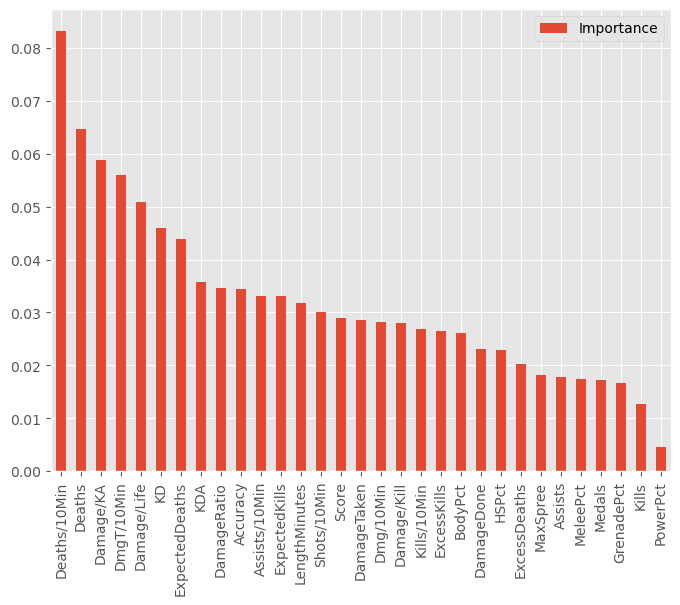

In [21]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [22]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500,
                           random_state=69, subsample=0.5)
Gradient Boosed Trees Accuracy: 0.6832298136645962
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70

''

In [23]:
ResultsOut(GBRT)

Acc: 0.683
MAE: 0.32
MSE: 0.32
RMSE: 0.56
R^2 Score: -0.28
OOS R^2 Score: -0.28
Log Loss: 11.42
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        71
           1       0.71      0.73      0.72        90

    accuracy                           0.68       161
   macro avg       0.68      0.68      0.68       161
weighted avg       0.68      0.68      0.68       161

---------------------------------------------------------


''

<Axes: >

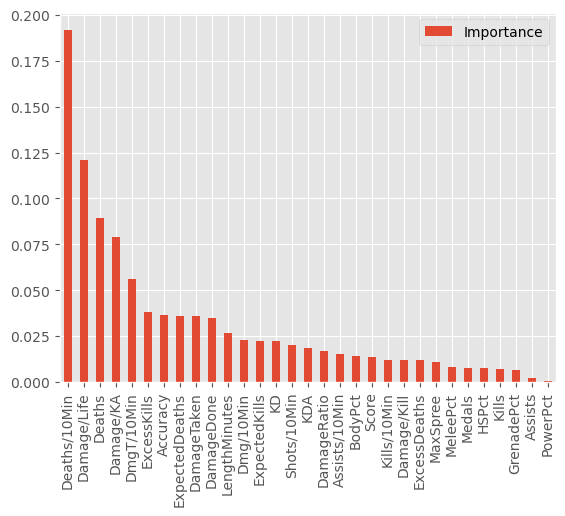

In [24]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [25]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [100,200,300,400,500],'learning_rate': [0.01,0.05,0.1,0.15],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7018633540372671
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                  0.01                1                 100  0.690552
1                  0.01                1                 200  0.706044
2  

''

In [26]:
ResultsOut(XGB)

Acc: 0.702
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.21
OOS R^2 Score: -0.21
Log Loss: 10.75
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        71
           1       0.72      0.76      0.74        90

    accuracy                           0.70       161
   macro avg       0.70      0.69      0.70       161
weighted avg       0.70      0.70      0.70       161

---------------------------------------------------------


''

<Axes: >

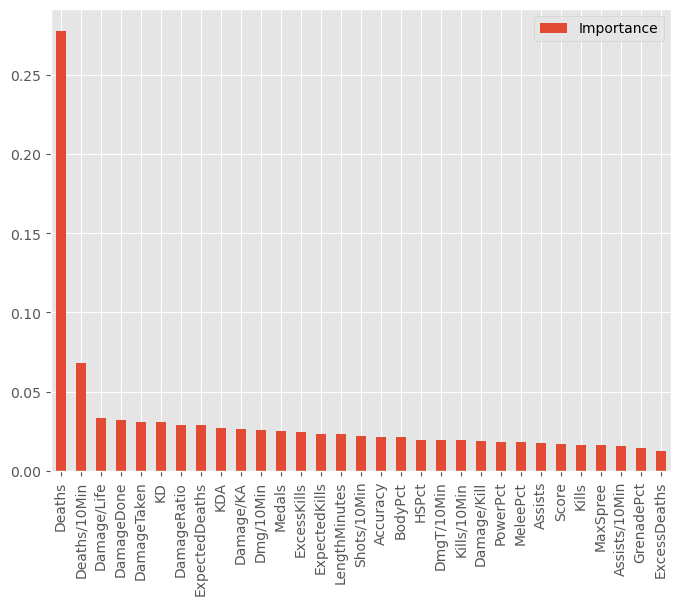

In [27]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [28]:
from sklearn.neural_network import MLPClassifier

param_grid_mlpc = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
mlpc = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_mlpc, n_jobs=-1)

mlpc.fit(X_train_preprocessed, y_train)
print(mlpc.best_estimator_)
print(f'Neural Net Accuracy: {mlpc.score(X_test_preprocessed, y_test)}')

/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaron

MLPClassifier(activation='identity', alpha=0.1, random_state=61)
Neural Net Accuracy: 0.7701863354037267


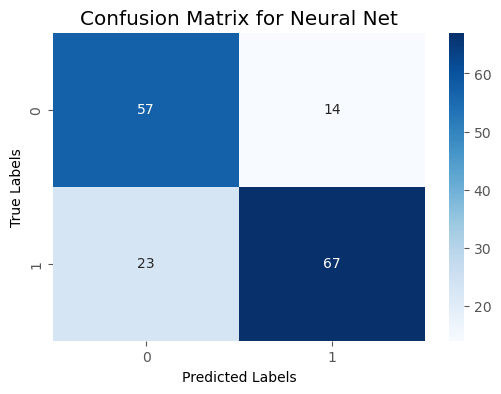

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

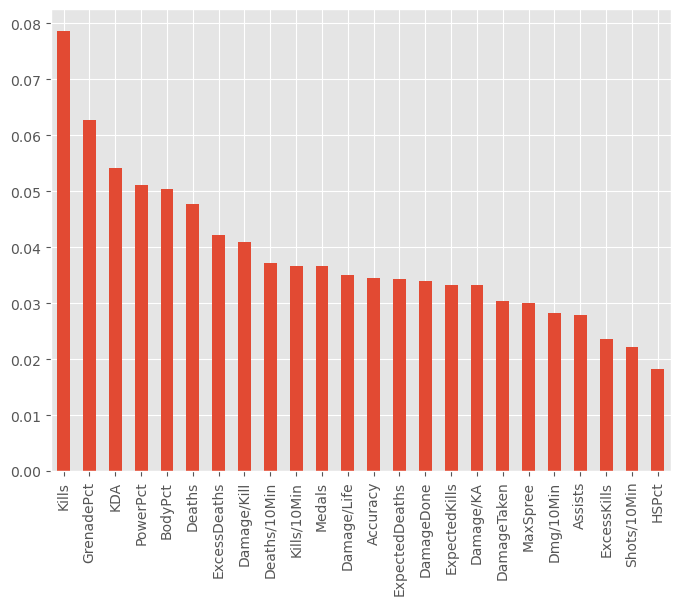

In [29]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, mlpc.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_mlpc = pd.DataFrame(mlpc.best_estimator_.coefs_[0].flatten()[:31], index=X_train.columns, columns=["Importance"])
feat_importances_mlpc = feat_importances_mlpc.abs().sum(axis=1)
feat_importances_mlpc = feat_importances_mlpc / feat_importances_mlpc.sum()
feat_importances_mlpc = feat_importances_mlpc.sort_values(ascending=False)[:24]
feat_importances_mlpc.plot(kind='bar', figsize=(8,6))

## Torch NN

In [30]:
# y_train.shape

In [31]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np

# # Assuming X_train_preprocessed and y_train are your NumPy arrays
# y_train_array = y_train.values
# X_train_preprocessed_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float)
# y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)

# class SimpleNeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(SimpleNeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x

# # Instantiate the model
# input_size = 30  # Replace with the actual input size
# hidden_size = 15 # Replace with the desired hidden layer size
# output_size = 2  # Replace with the actual output size
# model = SimpleNeuralNet(input_size, hidden_size, output_size)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Train the model on your trainsets
# # Replace X_train and y_train with your actual train data
# # Replace num_epochs with the desired number of training epochs
# losses = []
# accuracies = []
# prev_loss = float('inf')
# for epoch in range(100000):
#     optimizer.zero_grad()
#     outputs = model(X_train_preprocessed_tensor)
#     loss = criterion(outputs, y_train_tensor)
#     if loss >= prev_loss:
#         break
#     prev_loss = loss
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())
    
#     # Calculate training accuracy
#     with torch.no_grad():
#         predicted = torch.argmax(outputs, 1)
#         correct = (predicted == y_train_tensor).sum().item()
#         accuracy = correct / y_train_tensor.size(0)
#         accuracies.append(accuracy)

In [32]:
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)

# def closure():
#     optimizer.zero_grad()
#     outputs = model(X_train_preprocessed_tensor)
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
#     return loss

# # Train the model using the LBFGS optimizer with the closure function
# for epoch in range(100000):
#     optimizer.step(closure)

In [33]:
# # Assuming X_test_preprocessed and y_test are your test data
# X_test_preprocessed_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# # Evaluate the model on the test set
# with torch.no_grad():
#     test_outputs = model(X_test_preprocessed_tensor)
#     test_loss = criterion(test_outputs, y_test_tensor)
#     test_predicted = torch.argmax(test_outputs, 1)
#     test_correct = (test_predicted == y_test_tensor).sum().item()
#     test_accuracy = test_correct / y_test_tensor.size(0)

# print(f'Test Loss: {test_loss.item()}')
# print(f'Test Accuracy: {test_accuracy}')
# print(f'Epochs: {len(losses)}')

In [34]:
# import matplotlib.pyplot as plt
# epochs = range(1, len(losses) + 1)

# # Plotting training and validation losses
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, losses, label='Training Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting training and validation accuracies
# plt.subplot(1, 2, 2)
# plt.plot(epochs, accuracies, label='Training Accuracy')
# plt.title('Training and Validation Accuracy over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Ridge,0.770,0.230,0.230,0.479,0.068,0.068,8.283
1,ElasticNet,0.770,0.230,0.230,0.479,0.068,0.068,8.283
2,MLPC,0.770,0.230,0.230,0.479,0.068,0.068,8.283
3,Logistic Regression,0.764,0.236,0.236,0.486,0.043,0.043,8.507
4,Lasso,0.764,0.236,0.236,0.486,0.043,0.043,8.507
5,K-Nearest Neighbors,0.714,0.286,0.286,0.535,-0.159,-0.159,10.298
6,XGBoost,0.702,0.298,0.298,0.546,-0.209,-0.209,10.746
7,Random Forest,0.689,0.311,0.311,0.557,-0.260,-0.260,11.194
8,Gradient Boosted Trees,0.683,0.317,0.317,0.563,-0.285,-0.285,11.418


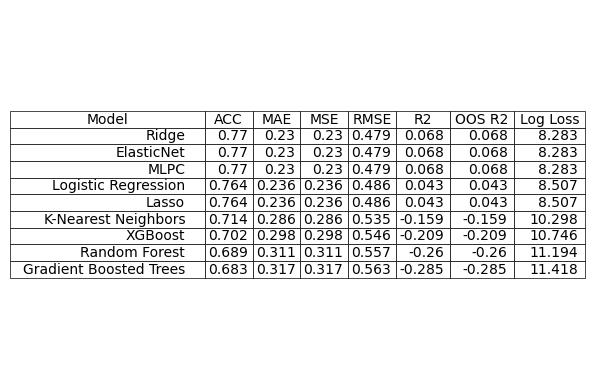

In [35]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,mlpc]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'MLPC']
from datetime import datetime
date = datetime.now().strftime("%m%d")

def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig(f'ModelResults/ModelResults{date}.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


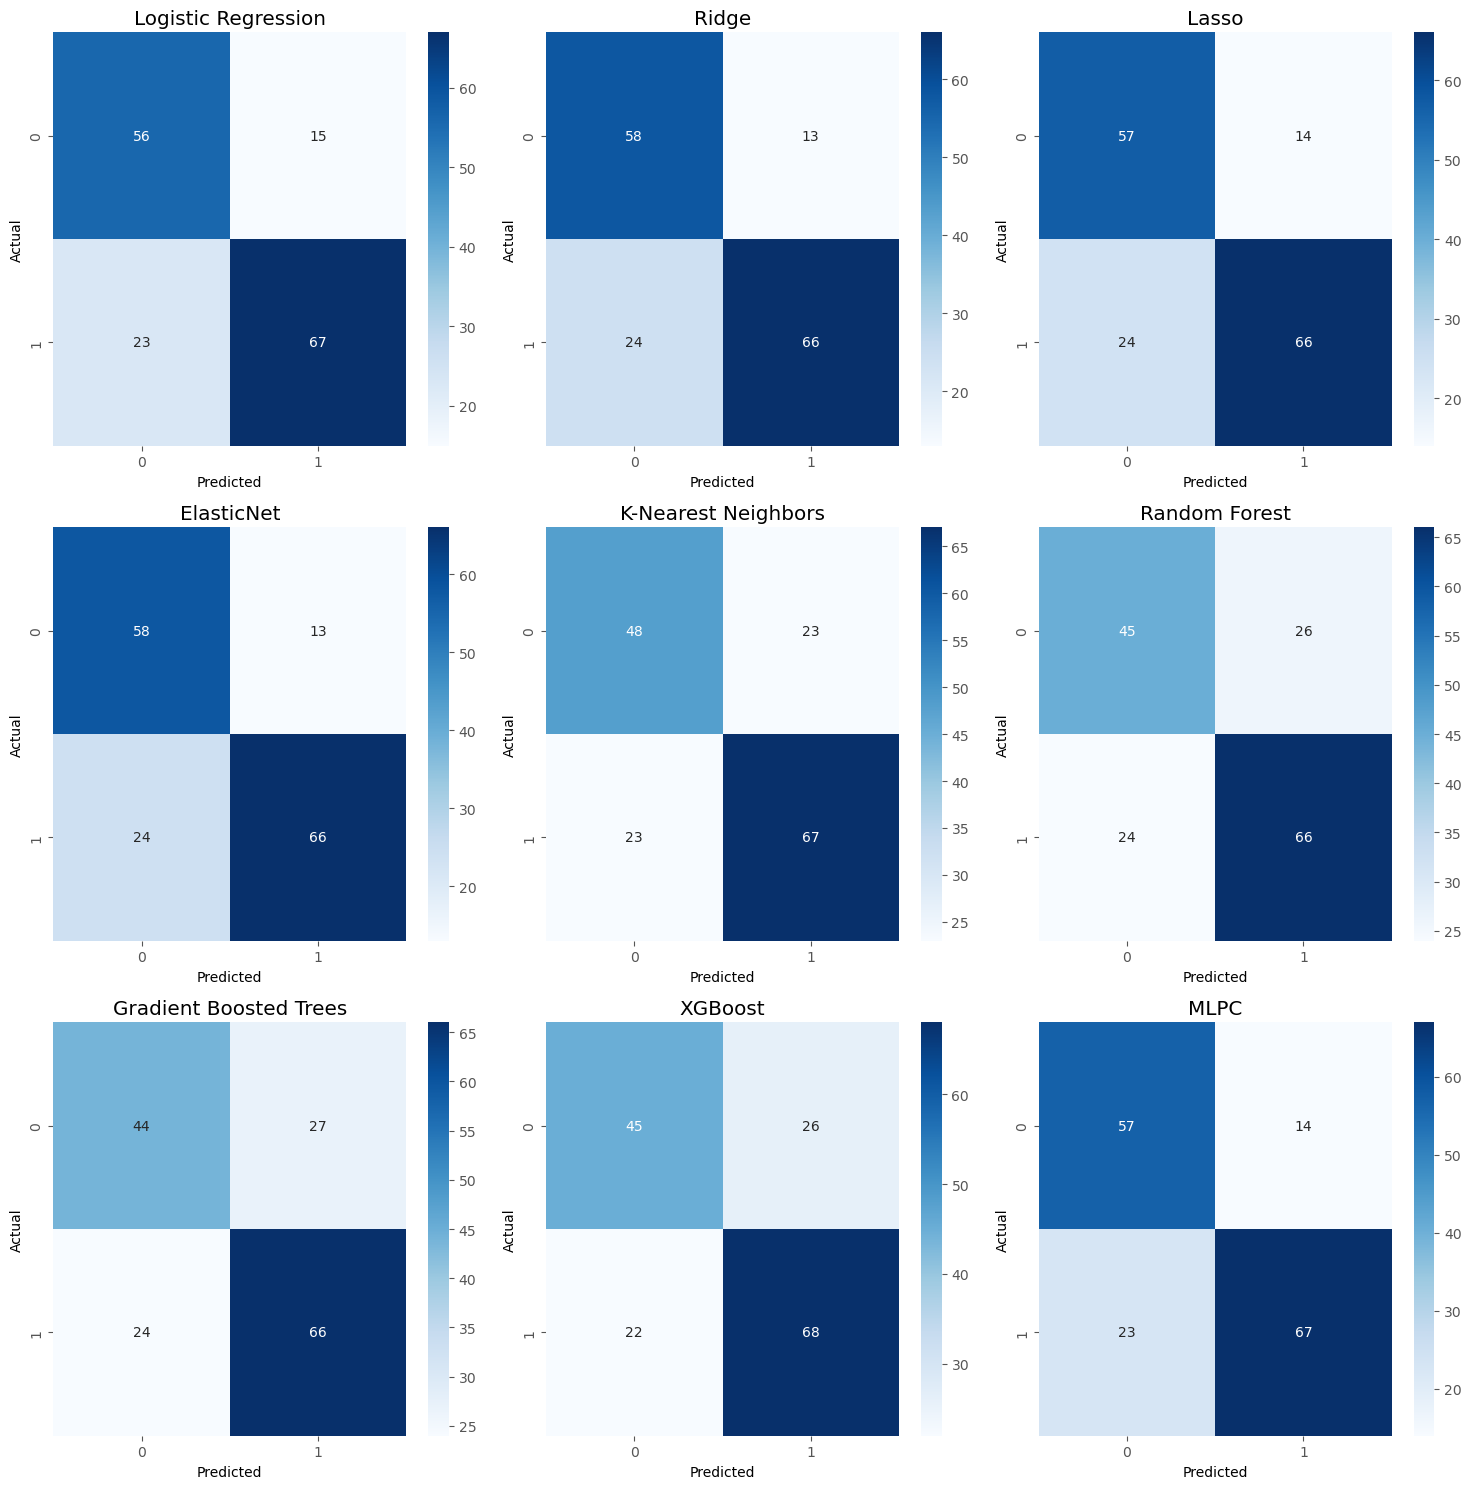

In [36]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(f'Plots/ConfusionMatrixMultigraph{date}.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 176.85s


In [38]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
DamageRatio,643.0,-0.0,1.001,-0.061,-0.048,-0.042,-0.036,25.324
Damage/KA,643.0,-0.0,1.001,-1.304,-0.582,-0.194,0.254,11.793
KD,643.0,-0.0,1.001,-1.322,-0.570,-0.214,0.242,11.518
PowerPct,643.0,0.0,1.001,-0.331,-0.331,-0.331,-0.331,7.381
Kills,643.0,0.0,1.001,-1.769,-0.568,0.033,0.633,6.638
Damage/Kill,643.0,0.0,1.001,-1.959,-0.663,-0.227,0.435,6.596
MeleePct,643.0,0.0,1.001,-1.154,-1.154,-0.093,0.596,6.027
Shots/10Min,643.0,0.0,1.001,-3.588,-0.594,-0.015,0.578,5.906
Damage/Life,643.0,-0.0,1.001,-2.166,-0.691,-0.137,0.507,5.569
Assists/10Min,643.0,0.0,1.001,-2.579,-0.681,-0.059,0.572,5.203
